In [92]:
import sys
import sklearn
from sklearn.datasets import fetch_openml
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [4]:
mnist = fetch_openml('mnist_784', version=1, as_frame = False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X, y = mnist['data'], mnist['target']

In [6]:
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

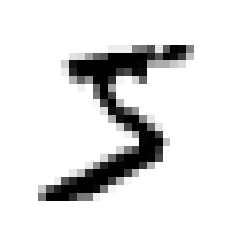

'5'

In [8]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()
y[0]

In [9]:
# Turn string into numbers
y = y.astype(np.uint8)

In [10]:
# Split the data into train and test set
# MNIST dataset already split into training set (first 60k images) and test (last 10k images)
X_train, X_test, y_train, y_test = X[:60000], X[:60000], y[:60000], y[60000:]

In [11]:
y_train_5 = (y_train == 5) # True for all 5s, false for all other digits
y_test_5 = (y_test == 5)

In [12]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

In [14]:
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [15]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [16]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [17]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [18]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [19]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [20]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [21]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [24]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [26]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [27]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

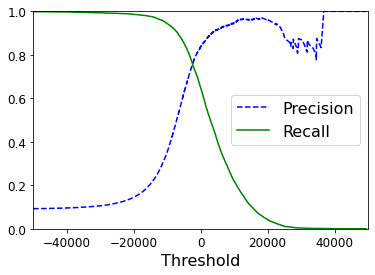

In [28]:
def plot_precision_recall_vs_threshold(precision, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1],'b--', label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label='Recall')
    plt.legend(loc='center right', fontsize=16)
    plt.xlabel('Threshold', fontsize=16)
    plt.grid=True
    plt.axis([-50000, 50000, 0, 1])
    # add more customization
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [29]:
threshold_90_precision = thresholds[np.argmax(precisions >=.90)]
threshold_90_precision

3370.0194991439557

In [30]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [31]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [32]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

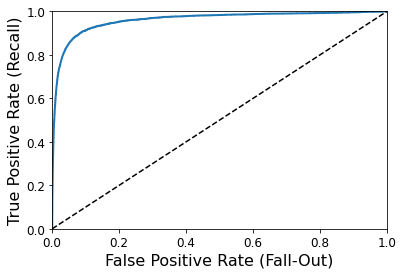

In [33]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
#    plt.grid(True)

plot_roc_curve(fpr, tpr)
plt.show()

In [34]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [35]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

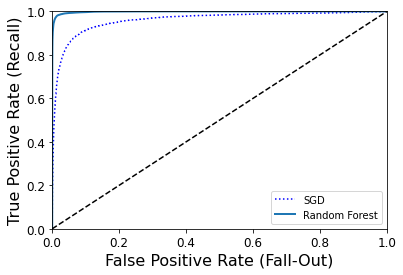

In [36]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
plt.plot(fpr, tpr, 'b:', label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [37]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

In [38]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [39]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [40]:
np.argmax(some_digit_scores)

5

In [41]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [42]:
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [43]:
len(ovr_clf.estimators_)

10

In [44]:
ovr_clf.decision_function([some_digit])

array([[-2.20788779, -2.52734154, -1.42209483, -0.89545795, -3.66438164,
         1.09884347, -3.13930844, -2.05006487, -2.51601851, -3.39312853]])

In [45]:
ovr_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [46]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [47]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [48]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [49]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [50]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [52]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

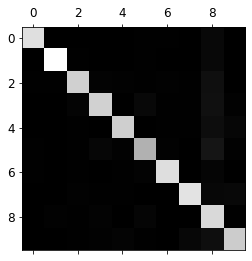

In [54]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [60]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
norm_conf_mx

array([[0.        , 0.        , 0.00371433, 0.00084417, 0.00135067,
        0.00725983, 0.006078  , 0.001013  , 0.03798751, 0.00016883],
       [0.        , 0.        , 0.00548799, 0.00355977, 0.0005933 ,
        0.00652625, 0.0005933 , 0.00103827, 0.03144468, 0.00148324],
       [0.00453172, 0.00453172, 0.        , 0.01544142, 0.01225243,
        0.00453172, 0.01124538, 0.0060423 , 0.06344411, 0.00184626],
       [0.00358832, 0.00277279, 0.01908335, 0.        , 0.00032621,
        0.03311042, 0.00440385, 0.00652422, 0.06573153, 0.0119067 ],
       [0.00205409, 0.00239644, 0.00701814, 0.00154057, 0.        ,
        0.00205409, 0.00581992, 0.0046217 , 0.05939747, 0.02807258],
       [0.00498063, 0.00276702, 0.00553403, 0.03099059, 0.00977679,
        0.        , 0.01383509, 0.00258255, 0.09869028, 0.01106807],
       [0.00506928, 0.00253464, 0.00709699, 0.00050693, 0.00743494,
        0.01639067, 0.        , 0.00050693, 0.02213586, 0.00016898],
       [0.00335196, 0.00159617, 0.0081404

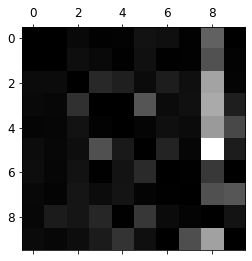

In [61]:
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [87]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [67]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train==cl_a) & (y_train_pred==cl_a)]
X_ab = X_train[(y_train==cl_a) & (y_train_pred==cl_b)]
X_ba = X_train[(y_train==cl_b) & (y_train_pred==cl_a)]
X_bb = X_train[(y_train==cl_b) & (y_train_pred==cl_b)]

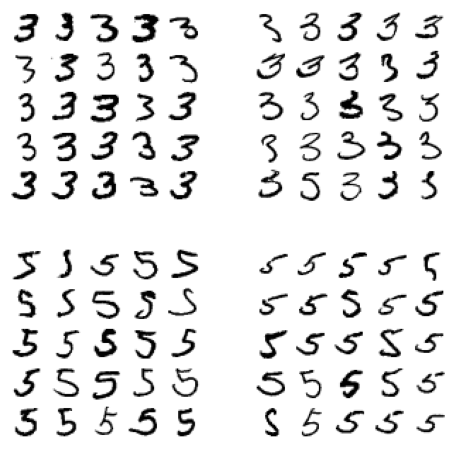

In [86]:
plt.figure(figsize=(8,8))
plt.subplot(221) ; plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222);plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223);plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224);plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [94]:
y_train_large = (y_train>= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel= np.c_[y_train_large, y_train_odd]
y_multilabel
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [97]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [98]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average = "macro")

0.976410265560605

In [99]:
f1_score(y_multilabel, y_train_knn_pred, average = "weighted")

0.9778357403921755

In [105]:
noise = np.random.randint(0,100,(len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test),784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

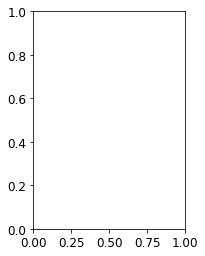

In [111]:
plt.subplot(121)
some_index = 0
plt.subplot(121); plot_digits(X_test_mod[some_index])
plt.subplot(122); plot_digits(y_test_mod[some_index])
plt.show()

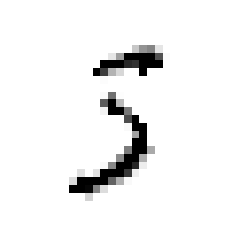

In [117]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digits(clean_digit)

In [119]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train_mod, y_train_mod, cv = 3)

In [120]:
f1_score(y_train, y_train_knn_pred, average = "macro")

ValueError: Classification metrics can't handle a mix of multiclass and multiclass-multioutput targets